# Achieving different fairness constraints on synthetic data

The `constraint` kwarg can take any of the following values:

    `"equalized_odds"`, `"demographic_parity"`, `"true_positive_rate_parity"`, `"false_positive_rate_parity"`.

Additionally, for `constraint="equalized_odds"`, you can use the `l_p_norm` kwarg to use a different l-p norm when computing the distance between group ROC points. Default is `l_p_norm=np.inf`.

---

**NOTE**: this notebook has extra requirements, install them with:
```
pip install "error_parity[dev]"
```

In [1]:
import logging
from itertools import product

import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve

In [2]:
from error_parity import __version__
print(f"Notebook ran using `error-parity=={__version__}`")

Notebook ran using `error-parity==0.3.11`


## **NOTE:** change the `FAIRNESS_CONSTRAINT` to your target fairness constraint.

In [3]:
FAIRNESS_CONSTRAINT = "true_positive_rate_parity"
# FAIRNESS_CONSTRAINT = "false_positive_rate_parity"
# FAIRNESS_CONSTRAINT = "demographic_parity"
# FAIRNESS_CONSTRAINT = "equalized_odds"

## Given some data (X, Y, S)

In [4]:
def generate_synthetic_data(n_samples: int, n_groups: int, prevalence: float, seed: int):
    """Helper to generate synthetic features/labels/predictions."""

    # Construct numpy rng
    rng = np.random.default_rng(seed)
    
    # Different levels of gaussian noise per group (to induce some inequality in error rates)
    group_noise = [0.1 + 0.4 * rng.random() / (1+idx) for idx in range(n_groups)]

    # Generate predictions
    assert 0 < prevalence < 1
    y_score = rng.random(size=n_samples)

    # Generate labels
    # - define which samples belong to each group
    # - add different noise levels for each group
    group = rng.integers(low=0, high=n_groups, size=n_samples)
    
    y_true = np.zeros(n_samples)
    for i in range(n_groups):
        group_filter = group == i
        y_true_groupwise = ((
            y_score[group_filter] +
            rng.normal(size=np.sum(group_filter), scale=group_noise[i])
        ) > (1-prevalence)).astype(int)

        y_true[group_filter] = y_true_groupwise

    ### Generate features: just use the sample index
    # As we already have the y_scores, we can construct the features X
    # as the index of each sample, so we can construct a classifier that
    # simply maps this index to our pre-generated predictions for this clf.
    X = np.arange(len(y_true)).reshape((-1, 1))
        
    return X, y_true, y_score, group

Generate synthetic data and synthetic predictions (there's no need to train a predictor, the predictor is seen as a black-box that outputs scores).

In [5]:
N_GROUPS = 4
# N_GROUPS = 3

# N_SAMPLES = 1_000_000
N_SAMPLES = 100_000

SEED = 23

X, y_true, y_score, group = generate_synthetic_data(
    n_samples=N_SAMPLES,
    n_groups=N_GROUPS,
    prevalence=0.25,
    seed=SEED)

In [6]:
actual_prevalence = np.sum(y_true) / len(y_true)
print(f"Actual global prevalence: {actual_prevalence:.1%}")

Actual global prevalence: 26.9%


In [7]:
EPSILON_TOLERANCE = 0.05
# EPSILON_TOLERANCE = 1.0  # best unconstrained classifier
FALSE_POS_COST = 1
FALSE_NEG_COST = 1

---
## Given a trained predictor (that outputs real-valued scores)

In [8]:
# Example predictor that predicts the synthetically produced scores above
predictor = lambda idx: y_score[idx].ravel()

## Construct the fair optimal classifier (derived from the given predictor)
- Fairness is measured by the equal odds constraint (equal FPR and TPR among groups);
    - optionally, this constraint can be relaxed by some small tolerance;
- Optimality is measured as minimizing the expected loss,
    - parameterized by the given cost of false positive and false negative errors;

In [9]:
from error_parity import RelaxedThresholdOptimizer

clf = RelaxedThresholdOptimizer(
    predictor=predictor,
    constraint=FAIRNESS_CONSTRAINT,
    tolerance=EPSILON_TOLERANCE,
    false_pos_cost=FALSE_POS_COST,
    false_neg_cost=FALSE_NEG_COST,
    max_roc_ticks=100,
    seed=SEED,
)

In [10]:
%%time
import logging
logging.basicConfig(level=logging.INFO, force=True)
clf.fit(X=X, y=y_true, group=group)

INFO:root:ROC convex hull contains 36.6% of the original points.
INFO:root:ROC convex hull contains 41.6% of the original points.
INFO:root:ROC convex hull contains 36.6% of the original points.
INFO:root:ROC convex hull contains 38.6% of the original points.
INFO:root:cvxpy solver took 0.000282458s; status is optimal.
INFO:root:Optimal solution value: 0.15335531408011688
INFO:root:Variable Global ROC point: value [0.10552007 0.71687162]
INFO:root:Variable ROC point for group 0: value [0.23852472 0.69338557]
INFO:root:Variable ROC point for group 1: value [0.11605835 0.69338557]
INFO:root:Variable ROC point for group 2: value [0.04159198 0.74338557]
INFO:root:Variable ROC point for group 3: value [0.03632111 0.74338557]


CPU times: user 152 ms, sys: 9 ms, total: 161 ms
Wall time: 242 ms


## Plot solution

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", rc={'grid.linestyle': ':'})

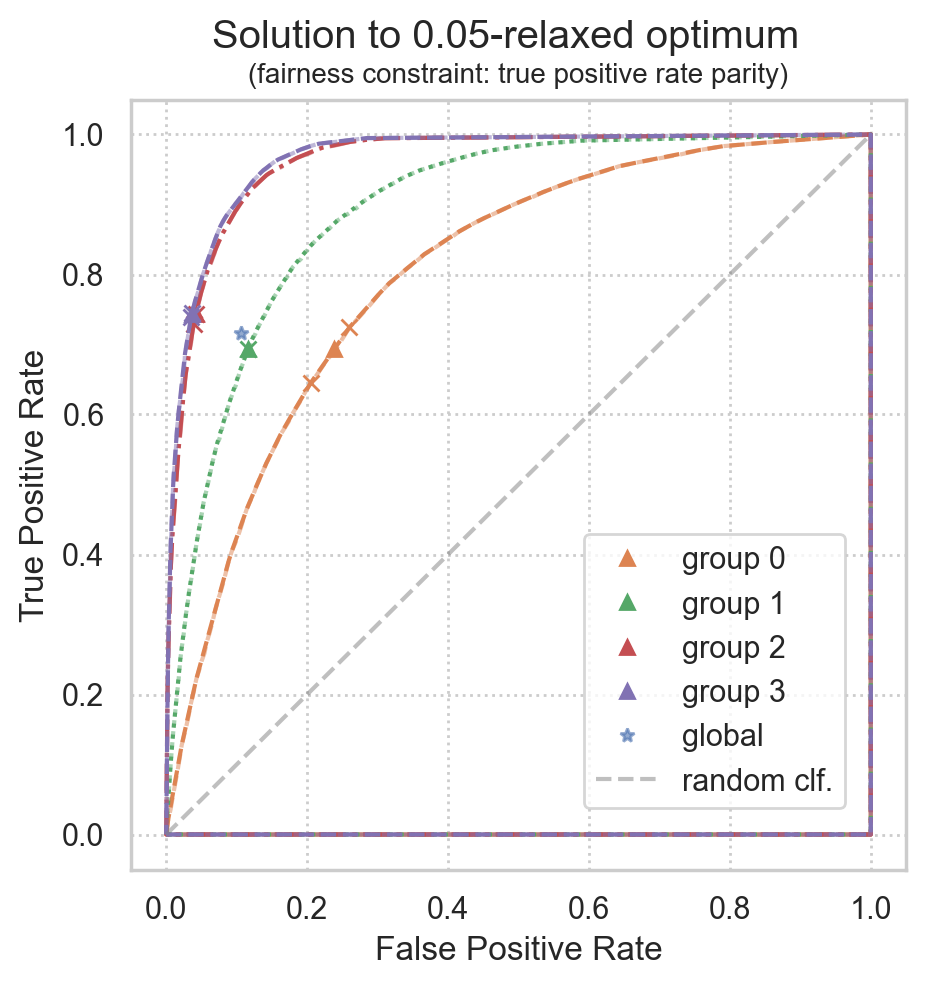

In [12]:
from error_parity.plotting import plot_postprocessing_solution

plot_postprocessing_solution(
    postprocessed_clf=clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
)
plt.show()

---
## Plot realized ROC points
> realized ROC points will converge to the theoretical solution for larger datasets, but some variance is expected for smaller datasets

In [13]:
# Set group-wise colors and global color
palette = sns.color_palette(n_colors=N_GROUPS + 1)
global_color = palette[0]
all_group_colors = palette[1:]

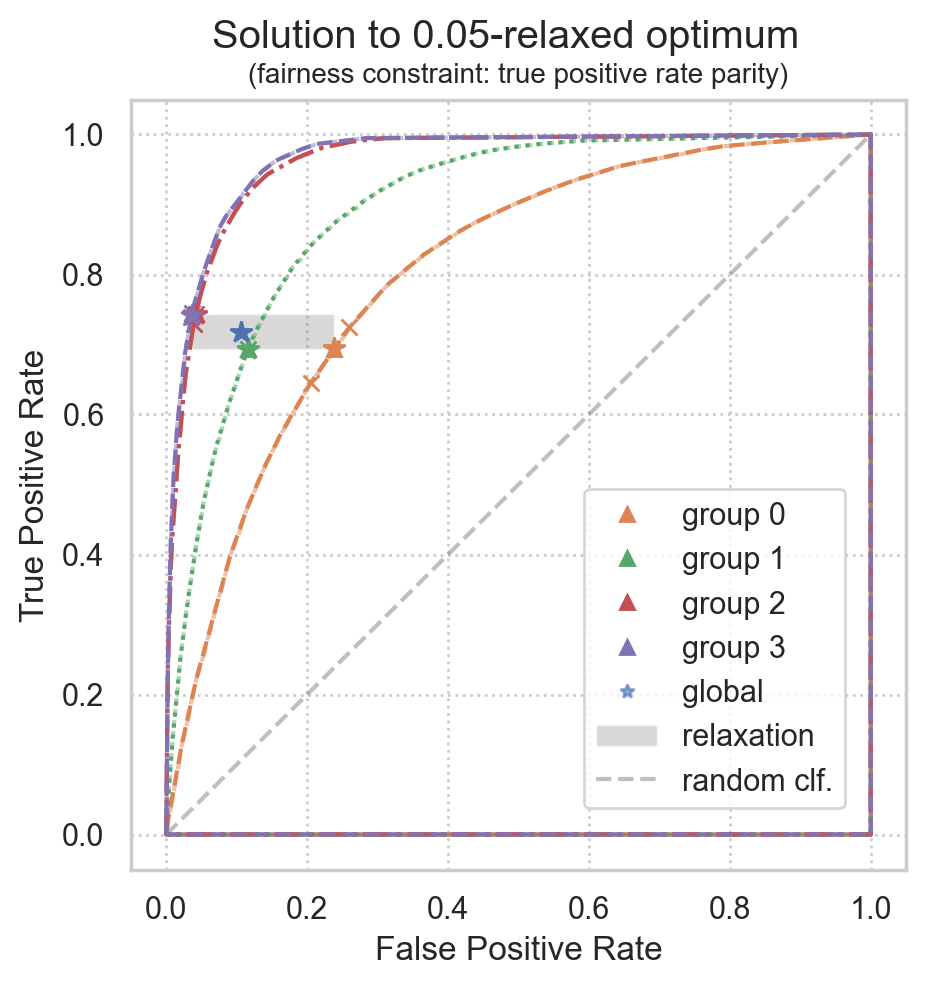

In [14]:
from error_parity.plotting import plot_postprocessing_solution
from error_parity.roc_utils import compute_roc_point_from_predictions

plot_postprocessing_solution(
    postprocessed_clf=clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
    plot_relaxation=True,
)

# Compute predictions
y_pred_binary = clf(X, group=group)

# Plot the group-wise points found
realized_roc_points = list()
for idx in range(N_GROUPS):

    # Evaluate triangulation of target point as a randomized clf
    group_filter = group == idx

    curr_realized_roc_point = compute_roc_point_from_predictions(y_true[group_filter], y_pred_binary[group_filter])
    realized_roc_points.append(curr_realized_roc_point)

    plt.plot(
        curr_realized_roc_point[0], curr_realized_roc_point[1],
        color=all_group_colors[idx],
        marker="*", markersize=8,
        lw=0,
    )

realized_roc_points = np.vstack(realized_roc_points)

# Plot actual global classifier performance
global_clf_realized_roc_point = compute_roc_point_from_predictions(y_true, y_pred_binary)
plt.plot(
    global_clf_realized_roc_point[0], global_clf_realized_roc_point[1],
    color=global_color,
    marker="*", markersize=8,
    lw=0,
)

plt.show()

### Compute distances between theorized ROC points and empirical ROC points

In [15]:
# Distances to group-wise targets:
for i, (target_point, actual_point) in enumerate(zip(clf.groupwise_roc_points, realized_roc_points)):
    dist = np.linalg.norm(target_point - actual_point, ord=2)
    print(f"Group {i}: l2 distance from target to realized point := {dist:.3%}")

# Distance to global target point:
dist = np.linalg.norm(clf.global_roc_point - global_clf_realized_roc_point, ord=2)
print(f"Global l2 distance from target to realized point   := {dist:.3%}")

Group 0: l2 distance from target to realized point := 0.199%
Group 1: l2 distance from target to realized point := 0.000%
Group 2: l2 distance from target to realized point := 0.003%
Group 3: l2 distance from target to realized point := 0.092%
Global l2 distance from target to realized point   := 0.036%


### Compute performance differences
> assumes FP_cost == FN_cost == 1.0

In [16]:
from sklearn.metrics import accuracy_score
from error_parity.roc_utils import calc_cost_of_point

# Empirical
accuracy_val = accuracy_score(y_true, y_pred_binary)

# Theoretical
theoretical_global_cost = calc_cost_of_point(
    fpr=clf.global_roc_point[0],
    fnr=1 - clf.global_roc_point[1],
    prevalence=y_true.sum() / len(y_true),
)

print(f"Actual accuracy: \t\t\t{accuracy_val:.3%}")
print(f"Actual error rate (1 - Acc.):\t\t{1 - accuracy_val:.3%}")
print(f"Theoretical cost of solution found:\t{theoretical_global_cost:.3%}")

Actual accuracy: 			84.678%
Actual error rate (1 - Acc.):		15.322%
Theoretical cost of solution found:	15.336%


### Compute empirical fairness violation

In [17]:
from error_parity.evaluation import evaluate_fairness

empirical_metrics = evaluate_fairness(
    y_true=y_true,
    y_pred=y_pred_binary,
    sensitive_attribute=group,
)

disparity_metric_map = {
    "equalized_odds": "equalized_odds_diff",

    "true_positive_rate_parity": "tpr_diff",
    "false_negative_rate_parity": "tpr_diff",

    "false_positive_rate_parity": "fpr_diff",
    "true_negative_rate_parity": "fpr_diff",
    
    "demographic_parity": "ppr_diff",
}

disparity_metric = disparity_metric_map[FAIRNESS_CONSTRAINT]

# Calculate empirical fairness violation
empirical_constraint_violation = empirical_metrics[disparity_metric]

# Check if empirical and theoretical results are reasonably close
print(f"Empirical {FAIRNESS_CONSTRAINT} violation:   {empirical_constraint_violation:.3}")
print(f"Theoretical {FAIRNESS_CONSTRAINT} violation: {clf.constraint_violation():.3}")
print(f"Max theoretical constraint violation:\t  {clf.tolerance:.3}")

INFO:root:Maximum fairness violation is between group=0 (p=[0.69338557]) and group=2 (p=[0.74338557]);


Empirical true_positive_rate_parity violation:   0.05
Theoretical true_positive_rate_parity violation: 0.05
Max theoretical constraint violation:	  0.05


---
---
# Plot Fairness-Accuracy Pareto frontier achievable by postprocessing

In [18]:
from error_parity.pareto_curve import compute_postprocessing_curve

postproc_results_df = compute_postprocessing_curve(
    model=predictor,
    fit_data=(X, y_true, group),
    eval_data={
        "fit": (X, y_true, group),
    },
    fairness_constraint=FAIRNESS_CONSTRAINT,
    predict_method="__call__",   # for callable predictors
    bootstrap=True,
    seed=SEED,
)

INFO:root:Using `n_jobs=9` to compute adjustment curve.
INFO:root:Computing postprocessing for the following constraint tolerances: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9 ].


  0%|          | 0/28 [00:00<?, ?it/s]

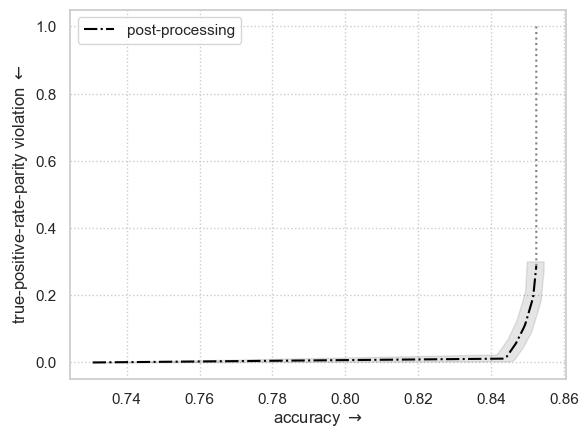

In [19]:
from error_parity.plotting import plot_postprocessing_frontier

plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric="accuracy",
    disp_metric=disparity_metric,
    show_data_type="fit",     # synthetic data example on the same data as used to fit the model
    constant_clf_perf=max((y_true == const_pred).mean() for const_pred in {0, 1}),
)

plt.xlabel(r"accuracy $\rightarrow$")
plt.ylabel(FAIRNESS_CONSTRAINT.replace("_", "-") + r" violation $\leftarrow$")
plt.show()

---